# Arboles Binarios

Un método de búsqueda por ı́ndices son los KD-trees, los cuales se basan en árboles
binarios. El método para construir los árboles binarios realiza cortes sobre la mediana de un
eje y produce un árbol de altura $log(n)$. El árbol puede ser construido de manera recursiva
con un costo $O(n \operatorname{log} n)$, el cual efectivamente es menor que la búsqueda exhaustiva $O(n2)$.
La Figura 1 muestra una árbol binario. Los hijos de cada nodo corresponden a la posición
de la mediana del eje seleccionado para cada profundidad.



In [1]:
import networkx as nx
import pandas as pd
import numpy as np

from math import radians, cos, sin, asin, sqrt

class Node:pass

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def kdtree_create(parent,point_list,depth=0):
    if len(point_list)==0:
        return
    D = len(point_list.columns) # assumes all points have the same dimension
    axis = depth % D
    key=point_list.columns[axis]
    A=point_list.sort_values(by=key)
    median = len(point_list)/2 # choose median
    # Create node and construct subtrees
    node = Node()
    node.axis=axis
    node.location = A.iloc[median]
    node.parent=parent
    node.bbox_min=np.min(A,axis=0)
    node.bbox_max=np.max(A,axis=0)
    node.left_child = kdtree_create(node.location,A.iloc[0:median], depth+1)
    node.right_child = kdtree_create(node.location,A.iloc[median+1:], depth+1)
    return node

def get_nearest_node(G,point):
    node_distances={}
    for g in G.nodes():
        dist=haversine(np.float(G.node[g]['y']),np.float(G.node[g]['x']),point[0],point[1])
        node_distances.update({g:dist})
    lookup_list = pd.Series(node_distances)
    min_dist= min(node_distances.values())
    return lookup_list[lookup_list.values == min_dist].index[0]

def get_point_list(G):
    point_list=pd.DataFrame()
    for g in G.nodes():
        lat=np.float(G.node[g]['y'])
        lon=np.float(G.node[g]['x'])
        df=pd.DataFrame([[lat,lon]],columns=['lat','lon'])
        if (len(point_list)==0):
            point_list=df
        else:
            point_list=point_list.append(df,ignore_index=True)
    return point_list




In [2]:
from scipy.spatial.distance import euclidean

def dfs_knn(kdtree,point,path=[],dist=euclidean,n=1):
    # DFS KNN search search
    if hasattr(kdtree,'location'):
        root=(kdtree.location[0],kdtree.location[1])
        p_dist=dist(point,root)
        path+=[[p_dist,root]]
        path.sort()
        l_leaf=kdtree.left_child
        if hasattr(l_leaf,'location'):
            dfs_knn(l_leaf,point,path,dist,n)
        r_leaf=kdtree.right_child
        if hasattr(r_leaf,'location'):
            dfs_knn(r_leaf,point,path,dist,n)
    return path[0:min(n,len(path))]

def dfs_range(kdtree,point,path=[],dist=euclidean,range=0):
    # DFS search range search
    if hasattr(kdtree,'location'):
        root=(kdtree.location[0],kdtree.location[1])
        p_dist=dist(point,root)
        if(p_dist<=range):
            path+=[root]
        l_leaf=kdtree.left_child
        if hasattr(l_leaf,'location'):
            dfs_range(l_leaf,point,path,dist,range)
        r_leaf=kdtree.right_child
        if hasattr(r_leaf,'location'):
            dfs_range(r_leaf,point,path,dist,range)
    return path

In [3]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15,8))
def draw_bbox(kdtree):
    if kdtree:
        parent=kdtree.parent
        child_node=kdtree.location
        min_val=kdtree.bbox_min
        max_val=kdtree.bbox_max 
        if not hasattr(parent,'data'):
            parent=child_node
        #print ("parent : x=%s,y=%s"%(parent[0],parent[1]))
        #print ("child : x=%s,y=%s"%(child_node[0],child_node[1]))
        #print '---------------'
        rect1=plt.Rectangle(parent-0.1,0.2,0.2, lw=2,fill=False,color='red')
        rect2=plt.Rectangle(min_val-0.1,max_val[0]-min_val[0]+0.2,max_val[1]-min_val[1]+0.2, lw=1,fill=False,alpha=0.9)
        plt.gca().add_patch(rect1)
        plt.gca().add_patch(rect2)
        if(kdtree.right_child):
            draw_bbox(kdtree.right_child)
        if(kdtree.left_child):
            draw_bbox(kdtree.left_child)
    return kdtree

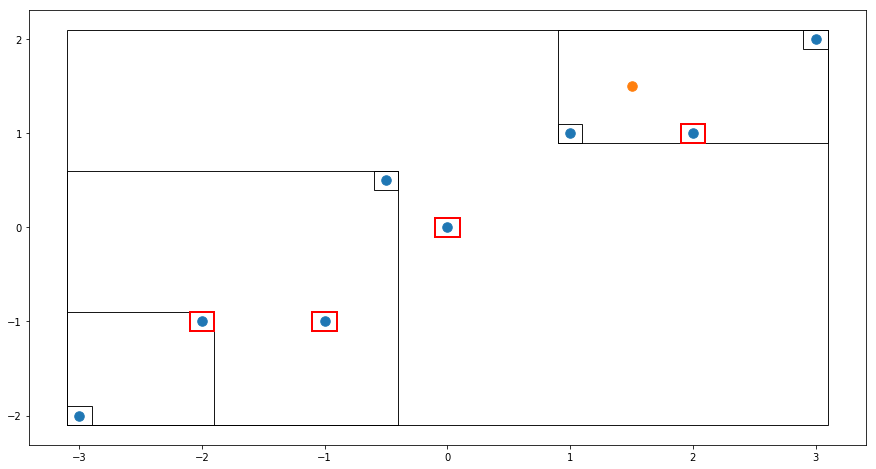

[[0.7071067811865476, (1.0, 1.0)], [0.7071067811865476, (2.0, 1.0)], [1.5811388300841898, (3.0, 2.0)], [2.1213203435596424, (0.0, 0.0)]]
[(0.0, 0.0), (-1.0, -1.0), (-2.0, -1.0), (-3.0, -2.0), (-0.5, 0.5), (2.0, 1.0), (1.0, 1.0), (3.0, 2.0)]


In [11]:
import matplotlib.pyplot as plt 

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1],[-0.5, 0.5], [0, 0], [2, 1], [3, 2]])
X= pd.DataFrame(X)

plt.figure(figsize=(15,8))
        
simple_tree=kdtree_create(Node(),X)
query=(1.5,1.5)
knn_path=dfs_knn(simple_tree,query,[],euclidean,4)
range_path=dfs_range(simple_tree,query,[],euclidean,10)

draw_bbox(simple_tree)
plt.scatter(X[0],X[1],s=90)
plt.scatter(query[0],query[1],s=90)
plt.show()


print knn_path
print range_path

Name: Talca,Chile
Type: MultiDiGraph
Number of nodes: 7607
Number of edges: 20203
Average in degree:   2.6558
Average out degree:   2.6558


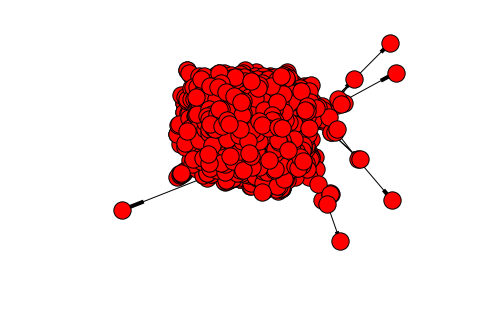

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
G=nx.read_graphml('data/talca_ciclovias.graphml')
print nx.info(G)
origin_point = (-35.434415,-71.620053)
destination_point = (-35.425901, -71.666645)

nx.draw(G)
plt.show()
#point_list=get_point_list(G)

#kdtree=kdtree_create(Node(),point_list)

De manera de consultar por los vecinos más próximos (nn), descendemos por el árbol y
mantenemos un punto candidato a ser el nn y un valor máximo conocido de la distancia
al punto de consulta. Luego chequeamos los sub-árboles dependiendo del eje de corte
continuamos por una de las ramas. Un ejemplo tı́pico es la búsqueda por rangos en consultas
geoespaciales.

In [5]:
root_node=kdtree.location
print root_node
print kdtree.left_child.location
print kdtree.right_child.location

lat   -35.432749
lon   -71.681489
Name: 5643, dtype: float64
lat   -35.447087
lon   -71.662497
Name: 7149, dtype: float64
lat   -35.415658
lon   -71.644622
Name: 1916, dtype: float64


In [12]:
def kdtree_knn(kdtree,point,n=1):
    #Retornar lista de n ciudades mas cercanas al punto point=(p1,p2)
    return None
def kdtree_range(kdtree,point,range=0):
    #Retornar lista de ciudades cercanas al punto point=(p1,p2) dentro de un rango
    return None